In [31]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [32]:
class PCA:

    def __init__(self):
        self.alpha_ = None
        self.D2_ = None
        self.DH2_ = None
        self.bound_ = None

    def fit(self, sample1, sample2):
        n1, n2 = sample1.shape[0], sample2.shape[0]
        n_features = sample1.shape[1]
        
        mean1 = np.mean(sample1, axis=0)
        mean2 = np.mean(sample2, axis=0)

        cov1 = np.cov(sample1, rowvar=False)
        cov2 = np.cov(sample2, rowvar=False)

        covariance_matrix = (1.0 / (n1 + n2 - 2)) * ((n1 - 1) * cov1 + (n2 - 1) * cov2)

        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        self.alpha_ = np.dot(mean1 - mean2, inv_covariance_matrix)

        z1 = np.dot(sample1, self.alpha_)
        z2 = np.dot(sample2, self.alpha_)

        z1_mean = np.mean(z1)
        z2_mean = np.mean(z2)

        z_var = np.dot(self.alpha_.T, np.dot(covariance_matrix, self.alpha_))
        
        self.D2_ = (z1_mean - z2_mean) ** 2 / z_var
        self.DH2_ = (n1 + n2 - n_features - 3) * self.D2_ / (n1 + n2 - 2) - n_features * (1 / n1 + 1 / n2)

        K = np.log(n2 / n1)
        F = lambda x : norm.cdf(x)
        
        self.P21_ = F(( K - 0.5 * self.DH2_) / np.sqrt(self.DH2_))
        self.P12_ = F(( -K - 0.5 * self.DH2_) / np.sqrt(self.DH2_))

        self.bound_ = (z1_mean + z2_mean) / 2 + K

    def predict(self, X):
        if self.alpha_ is None:
            raise RuntimeError("PCA is not fitted yet. Call fit() before transform.")
        
        return np.dot(X, self.alpha_) < self.bound_
    

In [94]:
def report(trainset1, trainset2, testset, true_values):
    pca = PCA()
    pca.fit(trainset1, trainset2)
    
    predictions = pca.predict(testset)
    
    accuracy = np.mean(predictions == true_values)

    confusion_matrix = np.zeros((2, 2), dtype=int)
    confusion_matrix[0, 0] = np.sum(predictions[true_values == 0] == 0)
    confusion_matrix[0, 1] = np.sum(predictions[true_values == 0] == 1)
    confusion_matrix[1, 0] = np.sum(predictions[true_values == 1] == 0)
    confusion_matrix[1, 1] = np.sum(predictions[true_values == 1] == 1)

    P21 = confusion_matrix[0, 1] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
    P12 = confusion_matrix[1, 0] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])

    print(f"Точность на тестовой выборке: {accuracy * 100:.2f}%")
    print(f"Оценки расстояния Махаланобиса:\n  смещенная D² = {pca.D2_}\n  несмещенная DH² = {pca.DH2_}")
    print(f"Оценки вероятности ошибочной классификации (2):\n  P(2|1) = {pca.P21_}\n  P(1|2) = {pca.P12_}")
    print(f"Эмпирические оценки вероятности ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

    fig = plt.figure(figsize =(16, 8))

    ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
    ax1.set_title('Тестовая выборка')
    ax1.scatter(testset[:, 0], testset[:, 1], testset[:, 2], c=predictions, cmap='coolwarm', alpha=0.5)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title('Матрица ошибок')
    ax2.imshow(confusion_matrix, cmap='coolwarm', interpolation='nearest')
    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(['1', '2'])
    ax2.set_yticklabels(['1', '2'])
    for (i, j), val in np.ndenumerate(confusion_matrix):
        ax2.text(j, i, f'{val}', ha='center', va='center', color='black')
        
    plt.show()


Точность на тестовой выборке: 100.00%
Оценки расстояния Махаланобиса:
  смещенная D² = 204.19587669898826
  несмещенная DH² = 203.36426953831048
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 3.6498382489089467e-13
  P(1|2) = 6.858305992853264e-13
Эмпирические оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.0
  Ṗ(1|2) = 0.0


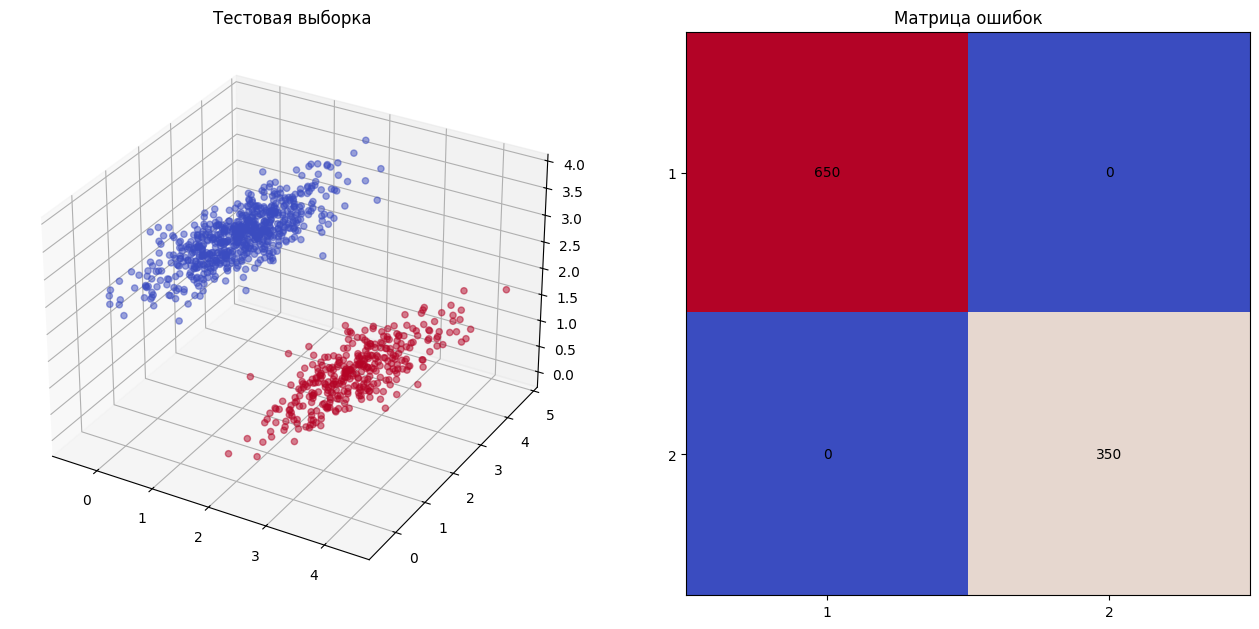

In [95]:
mean1 = np.array([1 ,2 ,3])
mean2 = np.array([3 ,2 ,1])
cov = np.matrix([[0.25 , 0.2 , 0.1], [0.2 , 0.64 , 0.15], [0.1 , 0.15 , 0.09]])

trainset1 = np.random.multivariate_normal(mean1, cov, 650)
trainset2 = np.random.multivariate_normal(mean2, cov, 350)

testset1 = np.random.multivariate_normal(mean1, cov, 650)
testset2 = np.random.multivariate_normal(mean2, cov, 350)

testset = np.vstack((testset1, testset2))
true_values = np.hstack((np.zeros(testset1.shape[0]), np.ones(testset2.shape[0])))

report(trainset1, trainset2, testset, true_values)

Точность на тестовой выборке: 87.40%
Оценки расстояния Махаланобиса:
  смещенная D² = 5.663673169974273
  несмещенная DH² = 5.6277862639218315
Оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.08615384615384615
  Ṗ(1|2) = 0.2
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 0.07393543741302878
  P(1|2) = 0.1774302770978724


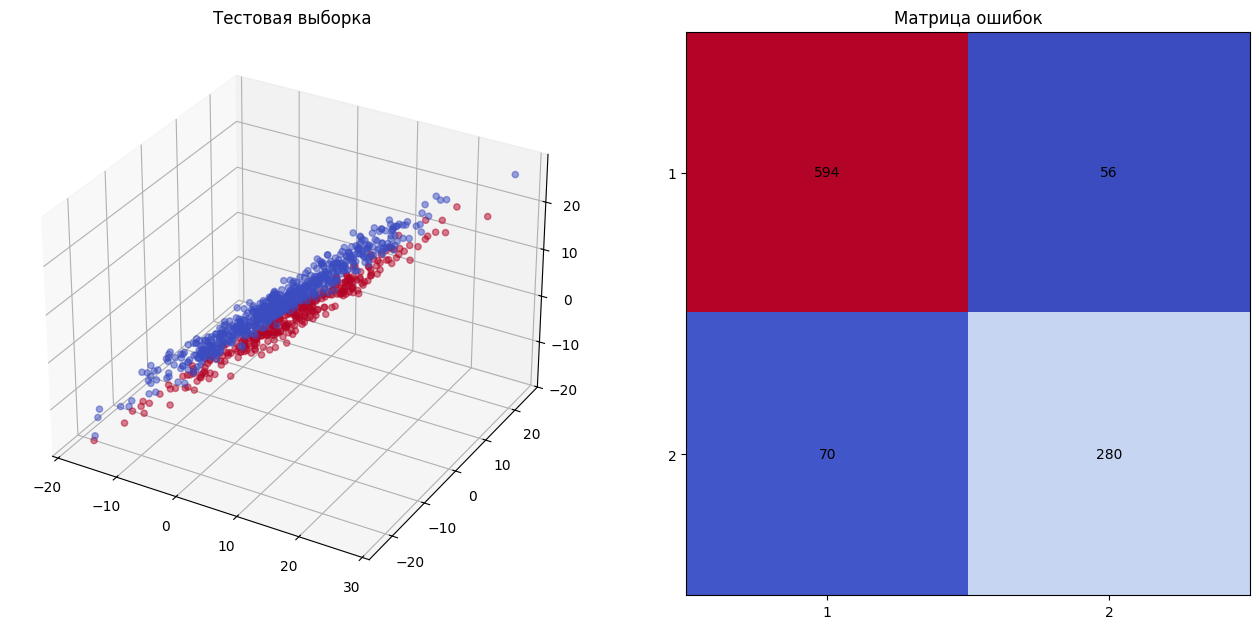

In [93]:
cov_bad = (cov + 2) * 20

trainset1_bad = np.random.multivariate_normal(mean1, cov_bad, 650)
trainset2_bad = np.random.multivariate_normal(mean2, cov_bad, 350)

testset1_bad = np.random.multivariate_normal(mean1, cov_bad, 650)
testset2_bad = np.random.multivariate_normal(mean2, cov_bad, 350)

testset_bad = np.vstack((testset1_bad, testset2_bad))
true_values_bad = np.hstack((np.zeros(testset1_bad.shape[0]), np.ones(testset2_bad.shape[0])))

report(trainset1_bad, trainset2_bad, testset_bad, true_values_bad)

In [115]:
def report_rep(trainset1, trainset2, testset, true_values):
    pca = PCA()
    pca.fit(trainset1, trainset2)
    
    predictions = pca.predict(testset)
    
    accuracy = np.mean(predictions == true_values)

    confusion_matrix = np.zeros((2, 2), dtype=int)
    confusion_matrix[0, 0] = np.sum(predictions[true_values == 0] == 0)
    confusion_matrix[0, 1] = np.sum(predictions[true_values == 0] == 1)
    confusion_matrix[1, 0] = np.sum(predictions[true_values == 1] == 0)
    confusion_matrix[1, 1] = np.sum(predictions[true_values == 1] == 1)

    P21 = confusion_matrix[0, 1] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
    P12 = confusion_matrix[1, 0] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])

    print(f"Точность на тестовой выборке: {accuracy * 100:.2f}%")
    print(f"Оценки расстояния Махаланобиса:\n  смещенная D² = {pca.D2_}\n  несмещенная DH² = {pca.DH2_}")
    print(f"Оценки вероятности ошибочной классификации (2):\n  P(2|1) = {pca.P21_}\n  P(1|2) = {pca.P12_}")
    print(f"Эмпирические оценки вероятности ошибочной классификации (1):\n  Ṗ(2|1) = {P21}\n  Ṗ(1|2) = {P12}")

    fig = plt.figure(figsize =(8, 8))

    ax1 = fig.add_subplot(1, 1, 1)
    ax1.set_title('Матрица ошибок')
    ax1.imshow(confusion_matrix, cmap='coolwarm', interpolation='nearest')
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(['1', '2'])
    ax1.set_yticklabels(['1', '2'])
    for (i, j), val in np.ndenumerate(confusion_matrix):
        ax1.text(j, i, f'{val}', ha='center', va='center', color='black')
        
    plt.show()


Точность на тестовой выборке: 78.50%
Оценки расстояния Махаланобиса:
  смещенная D² = 1.5869360988805263
  несмещенная DH² = 1.394362912825372
Оценки вероятности ошибочной классификации (2):
  P(2|1) = 0.09544358008250303
  P(1|2) = 0.5505803419744394
Эмпирические оценки вероятности ошибочной классификации (1):
  Ṗ(2|1) = 0.12142857142857143
  Ṗ(1|2) = 0.43333333333333335


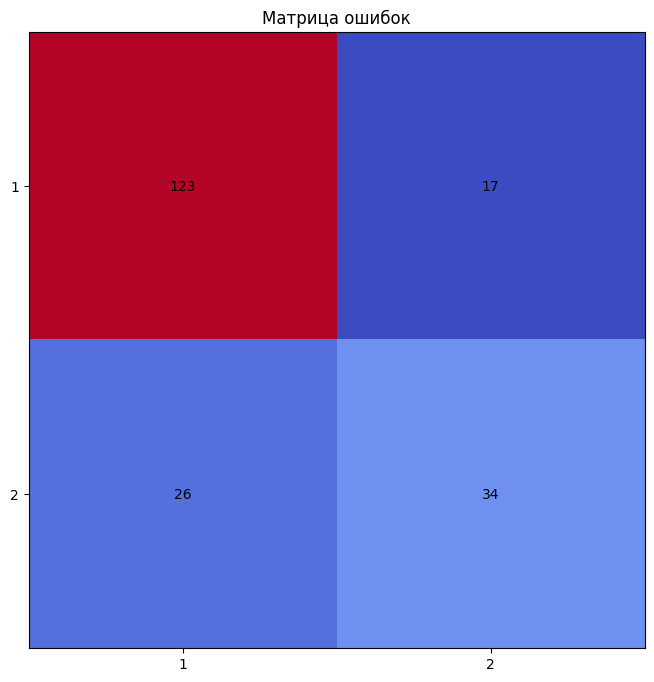

In [132]:
X, Y = [], []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y) - 1)
X = np.array(X)
Y = np.array(Y)

X1 = X[Y == 0]
X2 = X[Y == 1]
n1 = len(X1)
n2 = len(X2)

train_coefficient = 0.8

train_size1 = int(train_coefficient * n1)
train_size2 = int(train_coefficient * n2)

trainset1_rep = X1[:train_size1]
trainset2_rep = X2[:train_size2]

testset1_rep = X1[train_size1:]
testset2_rep = X2[train_size2:]

testset_rep = np.vstack((testset1_rep, testset2_rep))
true_values_rep = np.hstack((np.zeros(testset1_rep.shape[0]), np.ones(testset2_rep.shape[0])))

report_rep(trainset1_rep, trainset2_rep, testset_rep, true_values_rep)